      Date  31/01/23  30/09/18  31/08/22  30/09/22
0     0.33       NaN       NaN       NaN      3.88
1     0.42       NaN       NaN      3.08      4.13
2     0.50      3.53      0.79      3.24      4.32
3     0.58      3.52      0.80      3.35      4.45
4     0.67      3.50      0.80      3.41      4.54
..     ...       ...       ...       ...       ...
122  38.00      2.81      1.26      1.97      1.44
123  38.50      2.82      1.27      1.97      1.41
124  39.00      2.83      1.28      1.98      1.38
125  39.50      2.83      1.29      2.00      1.36
126  40.00      2.84      1.30      2.01      1.33

[127 rows x 5 columns]


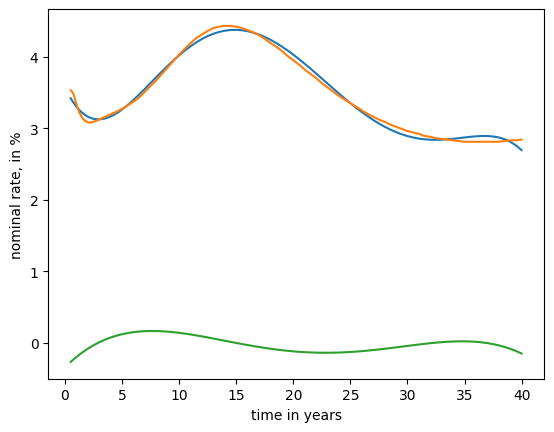

In [18]:
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("yield_curve_data.csv")
# the jan_curve file comes from GLC Nominal month end data_2016 to present, the jan 2023 curve, which is data from the Bank of England

print(data)

x = data[data["31/01/23"].notnull()]["Date"]
y = data[data["31/01/23"].notnull()]["31/01/23"]

spl = interpolate.UnivariateSpline(x,y,k=5)
plt.plot(x,spl(x))
plt.plot(x,y)
plt.plot(x,spl.derivative()(x))
plt.xlabel("time in years")
plt.ylabel("nominal rate, in %")

print(spl)

40
[-0.09592369 -0.06244385 -0.03235271 -0.00548885  0.01830917  0.03920281
  0.0573535   0.07292267  0.08607178  0.09696226  0.10575556  0.11261311
  0.11769636  0.12116674  0.1231857   0.12391468  0.12351512  0.12214847
  0.11997615  0.11715962  0.11386031  0.11023967  0.10645913  0.10268015
  0.09906415  0.09577258  0.09296688  0.09080849  0.08945885  0.08907941
  0.08983161  0.09187688  0.09537666  0.10049241  0.10738555  0.11621753
  0.1271498   0.14034378  0.15596093  0.17416268]


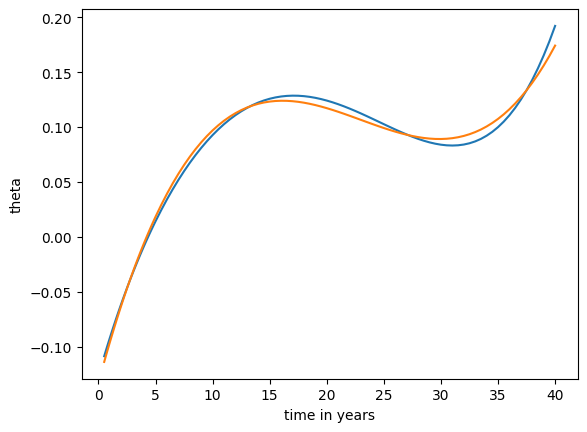

In [3]:
a = 0.1
sigma = 0.1

F = -spl.derivative()(x)
theta = -spl.derivative(n=2)(x) + a * F + sigma**2/a * (1-np.exp(-2 * a * x))

theta_spl = interpolate.UnivariateSpline(x, theta)
plt.plot(x,theta)
plt.plot(x,theta_spl(x))
plt.xlabel("time in years")
plt.ylabel("theta")

final_thetas = theta_spl(range(1,int(x[-1] + 1)))
print(len(final_thetas))
print( final_thetas)

The above code fits the yield curve to jan 2023 data. Below I fit two more yield curves, a downward sloping one from Sep 2022 and an upward sloping one from 30 Sep 18. 

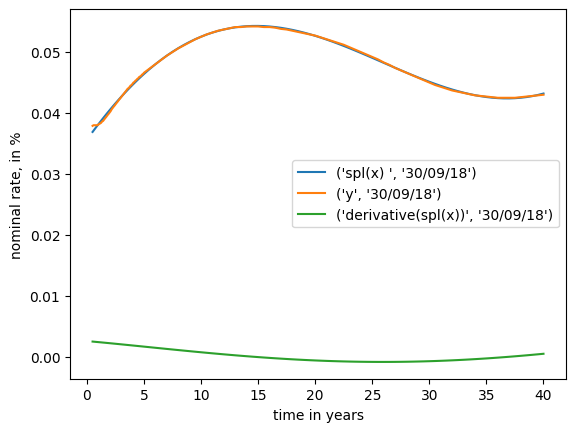

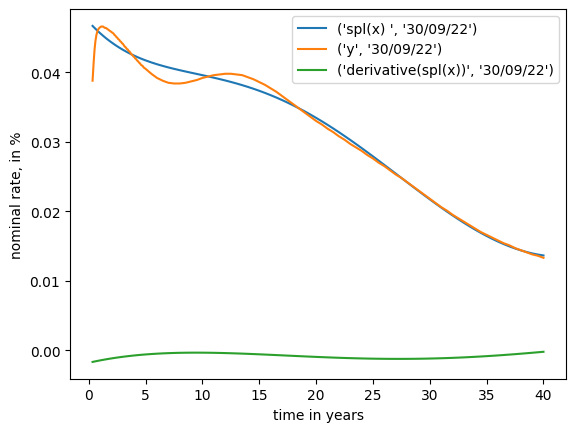

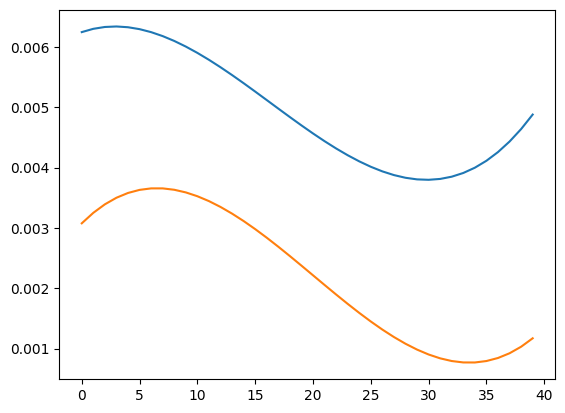

In [137]:
def generate_thetas(data, column_name, a=0.0001, sigma=0.0001):
    x = data[data[column_name].notnull()]["Date"] 
    y = data[data[column_name].notnull()][column_name]/100.0
    spl = interpolate.UnivariateSpline(x,y,k=5)
    plt.plot(x,spl(x), label=('spl(x) ',column_name))
    plt.plot(x,y, label=("y",column_name))
    plt.plot(x,spl.derivative()(x), label=("derivative(spl(x))",column_name))
    plt.xlabel("time in years")
    plt.ylabel("nominal rate, in %")
    plt.legend()
    plt.show()
    F = spl.derivative()(x)
    theta = F + a * spl(x) 
    theta_spl = interpolate.UnivariateSpline(x, theta)
    final_thetas = theta_spl(range(1,int(x.iloc[-1] + 1)))
    return final_thetas
    
data = pd.read_csv("yield_curve_data.csv")
# the jan_curve file comes from GLC Nominal month end data_2016 to present, the jan 2023 curve, which is data from the Bank of England

#print(data)
data["30/09/18"] += 3
thetas_18 = generate_thetas(data, "30/09/18",a=0.1)
#print(thetas_18)
np.savetxt("upward_curve.csv", thetas_18, delimiter=",")

thetas_22 = generate_thetas(data, "30/09/22", a=0.1)
#print(thetas_22)
np.savetxt("downward_curve.csv", thetas_22, delimiter=",")

plt.plot(thetas_18)
plt.plot(thetas_22)

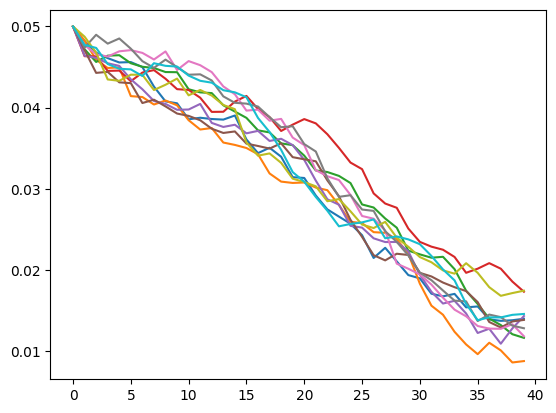

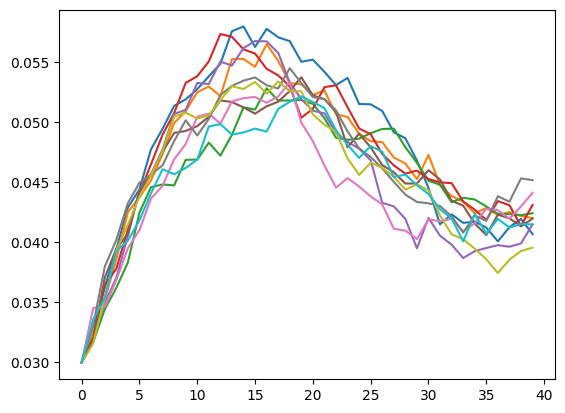

In [139]:
init = 0.05
series_len = 40
sample_series = np.zeros(series_len)
for j in range(10):
    sample_series[0] = init
    for i in range(series_len - 1):
        sample_series[i+1] = sample_series[i] + ((thetas_22[i] - 0.1*sample_series[i]) + np.random.normal(0,(1)) * 0.001)
    plt.plot(sample_series)
plt.show()
init = 0.03
series_len = 40
sample_series = np.zeros(series_len)
for j in range(10):
    sample_series[0] = init
    for i in range(series_len - 1):
        sample_series[i+1] = sample_series[i] + (thetas_18[i] - 0.1*sample_series[i]) + np.random.normal(0,(1)) * 0.001
    plt.plot(sample_series)

               Month       CPI     Short    Medium      Long  Ultra-Long
Month       1.000000  0.358596 -0.885336 -0.904331 -0.880437   -0.875096
CPI         0.358596  1.000000 -0.102965 -0.065602 -0.028241    0.192167
Short      -0.885336 -0.102965  1.000000  0.973662  0.873998    0.789675
Medium     -0.904331 -0.065602  0.973662  1.000000  0.957225    0.925299
Long       -0.880437 -0.028241  0.873998  0.957225  1.000000    0.996954
Ultra-Long -0.875096  0.192167  0.789675  0.925299  0.996954    1.000000


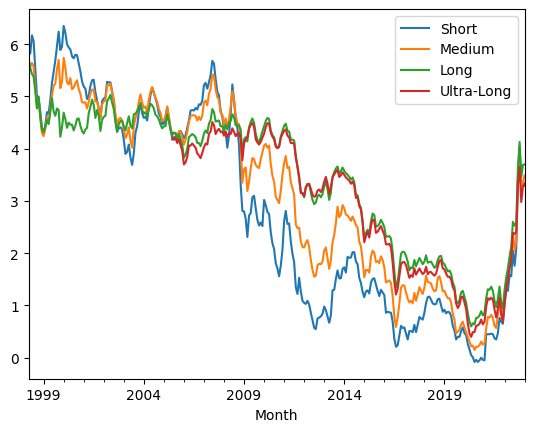

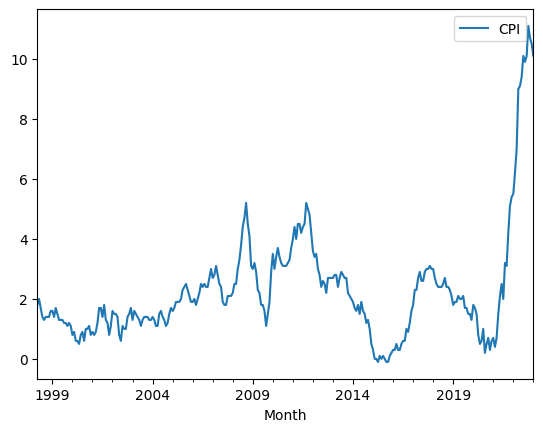

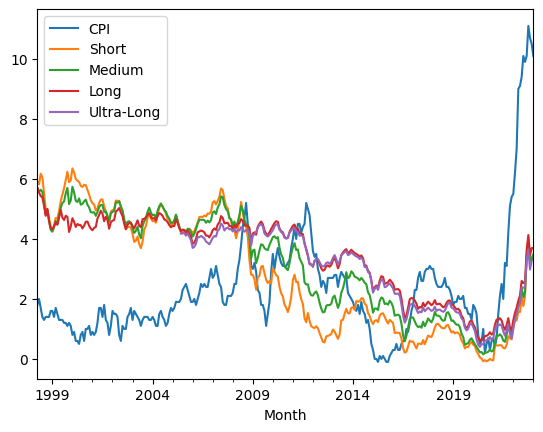

In [6]:
import pandas as pd
def strip_spaces(df):
    return df.replace(r"^ +| +$", r"", regex=True).rename(columns=lambda x: x.strip())

cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)
## load both data sets and find a way to make the timesteps the same 
## then find the pmcc of them both and use that in my model
cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
cpi_df = cpi_df[~(cpi_df['Month'] < gilt_df.iloc[0]['Month'])]
# cpi_df = cpi_df[~(cpi_df['Month'] < '01/01/2020')]

gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')
#gilt_df = gilt_df[~(gilt_df['Month'] > '01/01/2021')]
#gilt_df = gilt_df[~(gilt_df['Month'] < '01/01/2020')]

gilt_df.plot.line(x="Month")
# gilt_df.plot.line("Month","Short")
# gilt_df.plot("Month","Medium")
# gilt_df.plot("Month","Ultra-Long")
cpi_df.plot("Month","CPI")
df = pd.merge(cpi_df, gilt_df, how="outer", on="Month")
df.plot.line(x="Month")
print(df.corr(method="pearson"))

P-value:  0.03240206989863112
-2141.921383778924
-2135.355947712934
-2126.445731883154
-2116.017629846129
-2104.656631541192
-2095.4541125988917
-2083.951800524266
-2084.9962041326644
-2074.5927274477053
-2064.398608046349
-2052.82503366658
-2042.6368766704613
-2055.4646771564508
-2045.0558998399374
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                  248
Model:                     AutoReg(1)   Log Likelihood                1073.961
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Tue, 06 Jun 2023   AIC                          -2141.921
Time:                        19:21:56   BIC                          -2131.393
Sample:                             1   HQIC                         -2137.683
                                  248                                         
                 coef    std err          z      P>|z|      [0.025 

/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


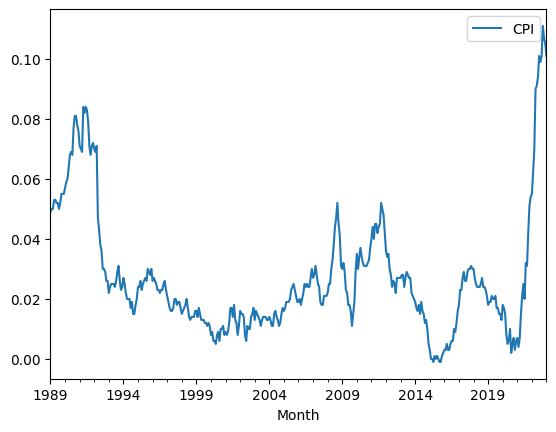

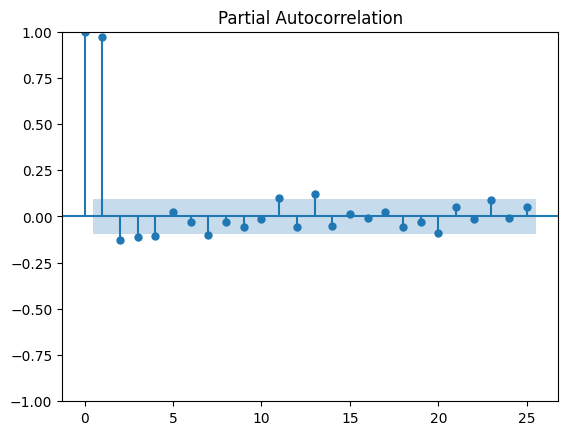

In [140]:
cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")
cpi_df['CPI'] = cpi_df['CPI'] * 0.01
cpi_df.plot("Month","CPI")
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(cpi_df['CPI'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(cpi_df['CPI'], lags=25)
plt.plot()
#
# Create training and test data
#
train_data = cpi_df['CPI'][:len(df)-50] 
test_data = cpi_df['CPI'][len(df)-50:] 
#
# Instantiate and fit the AR model with training data
#
smallestAIC = 3000000
bestModel = AutoReg(train_data, lags=1).fit()
for i in range(1,15):
    ar_model = AutoReg(train_data, lags=i).fit()
    print(ar_model.aic)
    if ar_model.aic < smallestAIC:
        smallestAIC = ar_model.aic
        bestModel = ar_model 
    
#
# Print Summary
#
print(bestModel.summary(0.05))

const     0.000383
CPI.L1    0.982335
dtype: float64


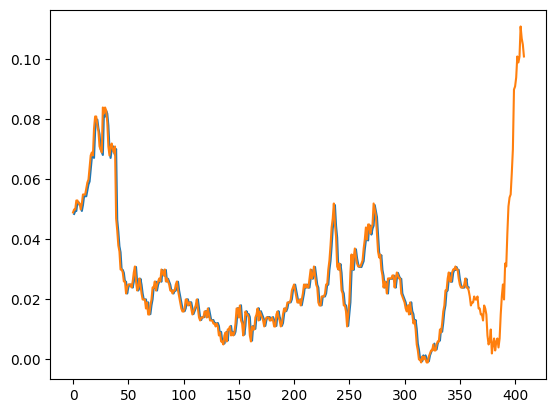

In [33]:
print(bestModel.params)
plt.plot(bestModel.fittedvalues)
plt.plot(cpi_df["CPI"])

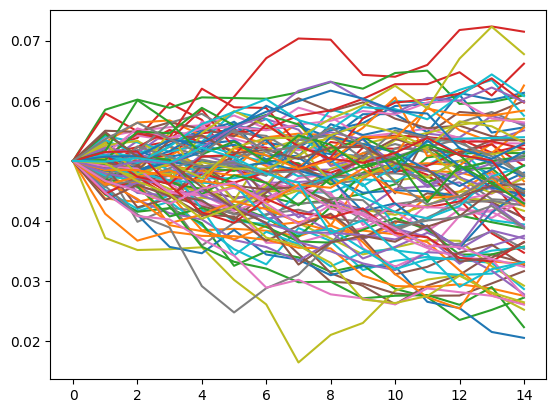

In [153]:
init = 0.05
series_len = 15
sample_series = np.zeros(series_len)
for j in range(100):
    sample_series[0] = 0.05
    for i in range(series_len - 1):
        sample_series[i+1] = bestModel.params[0] + sample_series[i] * bestModel.params[1] + np.random.normal(0,(0.003))
    plt.plot(sample_series)

P-value:  0.4078714157450344
                            AutoReg Model Results                             
Dep. Variable:                   Long   No. Observations:                  298
Model:                     AutoReg(1)   Log Likelihood                 113.205
Method:               Conditional MLE   S.D. of innovations              0.165
Date:                Tue, 25 Apr 2023   AIC                           -220.410
Time:                        17:06:03   BIC                           -209.328
Sample:                             1   HQIC                          -215.973
                                  298                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.027      1.416      0.157      -0.015       0.091
Long.L1        0.9869      0.007    134.546      0.000       0.973       1.001
                       

/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


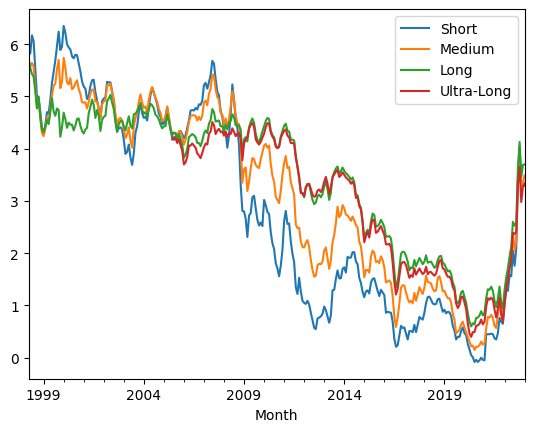

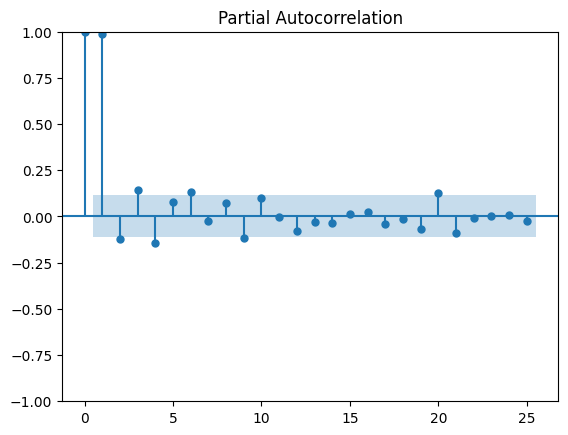

In [25]:
gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')

gilt_df.plot.line(x="Month")
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(gilt_df['Long'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(gilt_df['Long'], lags=25)

#
# Create training and test data
#
train_data = gilt_df['Long'][:len(df)-100]
test_data = gilt_df['Long'][len(df)-100:]
#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(train_data, lags=1).fit()
#
# Print Summary
#
print(ar_model.summary(0.05))

In [9]:
def price_bond(coupon_rate, face_val, current_rate, N):
    price = 0
    for i in range(1,N):
        price += (coupon_rate * face_val) / (1 + current_rate)**(i)
    price += ((coupon_rate + 1) * face_val) / (1 + current_rate)**(N)
    return price
print(price_bond(0.05, 100, 0.04, 10))

108.110895779355


In [149]:
cpi_df.head()
ratios = cpi_df["CPI"].shift(1) / cpi_df["CPI"]
print(sum(ratios < 1.0))
print(len(ratios))
print(sum(ratios > 1.05))

172
409
127
